# 1. Data Collection and Preparation



I have selected a kaagle dataset for Oniline Purchase Transaction.

In [1]:
import pandas as pd
import datetime as dt

# Load the dataset
df = pd.read_csv('file.csv',index_col=None)

In [2]:
df.head()

,Unnamed: 0,CustomerID,Gender,Location,Tenure_Months,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,...,Avg_Price,Delivery_Charges,Coupon_Status,GST,Date,Offline_Spend,Online_Spend,Month,Coupon_Code,Discount_pct
0,0,17850.0,M,Chicago,12.0,16679.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
1,1,17850.0,M,Chicago,12.0,16680.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Used,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
2,2,17850.0,M,Chicago,12.0,16696.0,2019-01-01,GGOENEBQ078999,Nest Cam Outdoor Security Camera - USA,Nest-USA,...,122.77,6.5,Not Used,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
3,3,17850.0,M,Chicago,12.0,16699.0,2019-01-01,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,...,81.50,6.5,Clicked,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0
4,4,17850.0,M,Chicago,12.0,16700.0,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,...,153.71,6.5,Clicked,0.1,1/1/2019,4500.0,2424.5,1.0,ELEC10,10.0


In [3]:
df.dtypes

Unnamed: 0               int64
CustomerID             float64
Gender                  object
Location                object
Tenure_Months          float64
Transaction_ID         float64
Transaction_Date        object
Product_SKU             object
Product_Description     object
Product_Category        object
Quantity               float64
Avg_Price              float64
Delivery_Charges       float64
Coupon_Status           object
GST                    float64
Date                    object
Offline_Spend          float64
Online_Spend           float64
Month                  float64
Coupon_Code             object
Discount_pct           float64
dtype: object

# 2. Data Cleaning and Transformation

In [4]:
# Convert 'Transaction_Date' and 'Date' to datetime format
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])
df['Date'] = pd.to_datetime(df['Date'])

# Check for missing values
print(df.isnull().sum())

Unnamed: 0              0
CustomerID              0
Gender                  0
Location                0
Tenure_Months           0
Transaction_ID          0
Transaction_Date        0
Product_SKU             0
Product_Description     0
Product_Category        0
Quantity                0
Avg_Price               0
Delivery_Charges        0
Coupon_Status           0
GST                     0
Date                    1
Offline_Spend           1
Online_Spend            1
Month                   1
Coupon_Code            41
Discount_pct           41
dtype: int64


In [5]:
# Drop rows with missing values
df = df.dropna()

In [6]:
df.shape

(5930, 21)

In [7]:
# Creating new column Total amount spend vy the customer
df['TotalAmount'] = df['Online_Spend'] + df['Offline_Spend']

# 3. RFM Calculation

- Recency (R): Measure the time since the last purchase of each customer.

- Frequency (F): Count the number of transactions made by each customer over a specific period.

- Monetary Value (M): Calculate the total amount spent by each customer during the analyzed timeframe.




Lets set current date as a day after most recent transaction date.

So, Recency will be the difference between the current date and the last transaction date for that customer.

Frequency wiil be the count of transactions done by that customers.

Lastly, Monetary will the sum of total transactions made by that customer.

In [8]:
# Calculate Recency, Frequency, and Monetary Value
current_date = max(df['Transaction_Date']) + pd.DateOffset(days=1)

rfm = df.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (current_date - x.max()).days,
    'Transaction_ID': 'count',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [9]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12350.0,18,6,44605.86
1,12373.0,25,7,48272.98
2,12410.0,11,7,53289.11
3,12414.0,18,2,14868.62
4,12431.0,363,14,98397.18


# Customer Segmentation

### Score
Lets scale customers w.r.t there RFM_metrics
This is what the score represents:
####1.   RECENCY
      
      Dormant=1
      
      Churn=2
     
      Active=3

      Loyal=4
####2.   Frequency/ Monetary

      Low=1

      Mid=2

      Mid-High=3

      High=4



In [10]:
# Define quartiles for each metric
recency_quartiles = pd.qcut(rfm['Recency'], q=4, labels=['4', '3', '2', '1'])
frequency_quartiles = pd.qcut(rfm['Frequency'], q=4, labels=['1', '2', '3', '4'])
monetary_quartiles = pd.qcut(rfm['Monetary'], q=4, labels=['1', '2', '3', '4'])

In [11]:
# Assign RFM segments to each customer
rfm['RecencyCategory'] = recency_quartiles
rfm['FrequencyCategory'] = frequency_quartiles
rfm['MonetaryCategory'] = monetary_quartiles

In [12]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,RecencyCategory,FrequencyCategory,MonetaryCategory
0,12350.0,18,6,44605.86,4,2,3
1,12373.0,25,7,48272.98,3,2,3
2,12410.0,11,7,53289.11,4,2,3
3,12414.0,18,2,14868.62,4,1,1
4,12431.0,363,14,98397.18,1,3,4


In [13]:
rfm1=rfm.copy()

In [14]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm1['Segment'] = rfm1['RecencyCategory'].astype(str) + rfm1['FrequencyCategory'].astype(str)
rfm1['Segment'] = rfm1['Segment'].replace(seg_map, regex=True)

rfm1.head()

,CustomerID,Recency,Frequency,Monetary,RecencyCategory,FrequencyCategory,MonetaryCategory,Segment
0,12350.0,18,6,44605.86,4,2,3,Potential Loyalists
1,12373.0,25,7,48272.98,3,2,3,About to Sleep
2,12410.0,11,7,53289.11,4,2,3,Potential Loyalists
3,12414.0,18,2,14868.62,4,1,1,Promising
4,12431.0,363,14,98397.18,1,3,4,At Risk


In [15]:
rfm1.dtypes

CustomerID            float64
Recency                 int64
Frequency               int64
Monetary              float64
RecencyCategory      category
FrequencyCategory    category
MonetaryCategory     category
Segment                object
dtype: object

In [16]:
rfmStats1 = rfm1[["Segment","Recency","Frequency", "Monetary"]].groupby("Segment").agg(["mean","count"])
rfmStats1.columns = rfmStats1.columns.map('_'.join).str.strip('|')
rfmStats1


,Recency_mean,Recency_count,Frequency_mean,Frequency_count,Monetary_mean,Monetary_count
Segment,,,,,,
About to Sleep,22.828125,64,4.437500,64,26680.576406,64
At Risk,334.321429,112,28.991071,112,138794.651875,112
Hibernating,306.825581,86,4.023256,86,19909.131860,86
Loyal Customers,14.606061,33,36.909091,33,231652.699697,33
Need Attention,23.666667,18,12.222222,18,74560.835000,18
Potential Loyalists,10.857143,56,9.732143,56,64928.228571,56
Promising,11.500000,32,2.187500,32,15337.057500,32


In [17]:
rfmStats1.describe()

,Recency_mean,Recency_count,Frequency_mean,Frequency_count,Monetary_mean,Monetary_count
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,103.515001,57.285714,14.071826,57.285714,81694.740130,57.285714
std,148.576561,33.260158,13.548737,33.260158,78874.541430,33.260158
min,10.857143,18.000000,2.187500,18.000000,15337.057500,18.000000
25%,13.053030,32.500000,4.230378,32.500000,23294.854133,32.500000
50%,22.828125,56.000000,9.732143,56.000000,64928.228571,56.000000
75%,165.246124,75.000000,20.606647,75.000000,106677.743438,75.000000
max,334.321429,112.000000,36.909091,112.000000,231652.699697,112.000000


#### Segment Statsistics
I will make my comments according to the descriptive statistics above. The 7 segments are:


1.   About to Sleep
2.   At Risk
3.   Hibernating
4.   Loyal Customers
5.   Need Attention
6.   Potential Loyalists
7.   Promising



###1. **About to Sleep**

There are **164** people in this group.

They do not shop for an average of **95.2** days.

They shop for an average of **9.84** times.

They spend an average of **45083.46** units of money.


### 2. At Risk

There are **279** people in this group.

They do not shop for an average of **225.16** days.

They shop for an average of **52** times.

They spend an average of **230628.835** units of money.


###3. Hibernating

There are **235.9** people in this group.

They do not shop for an average of **58.7** days.

They shop for an average of **9.5** times.

They spend an average of **41771.4** units of money.


###4. Loyal Customers

There are **236** people in this group.

They do not shop for an average of **24.8** days.

They shop for an average of **101.42** times.

They spend an average of **490105.12** units of money.


###5. Need Attention

There are **102** people in this group.

They do not shop for an average of **5.9** days.

They shop for an average of **33** times.

They spend an average of **152121.26** units of money.


###6. Potential Loyalists

There are **181** people in this group.

They do not shop for an average of **26.72** days.

They shop for an average of **24.79** times.

They spend an average of **135873.43** units of money.


###7. Promising

There are **58** people in this group.

They do not shop for an average of **22.51** days.

They shop for an average of **5.6** times.

They spend an average of **35091** units of money.




# Insights and Interpretation

In [24]:
import pandas as pd
import plotly.express as px
segment_counts = rfm1['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'CustomerCount']


# Create TreeMap using Plotly Express
fig = px.treemap(segment_counts, path=['Segment'], values='CustomerCount',
                 title='Customer Segmentation TreeMap',
                 labels={'CustomerCount': 'Customer Count'})

# Show the plot
fig.show()


<ipython-input-25-074c9212d4c5>:9: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


<ipython-input-25-074c9212d4c5>:13: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


<ipython-input-25-074c9212d4c5>:17: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




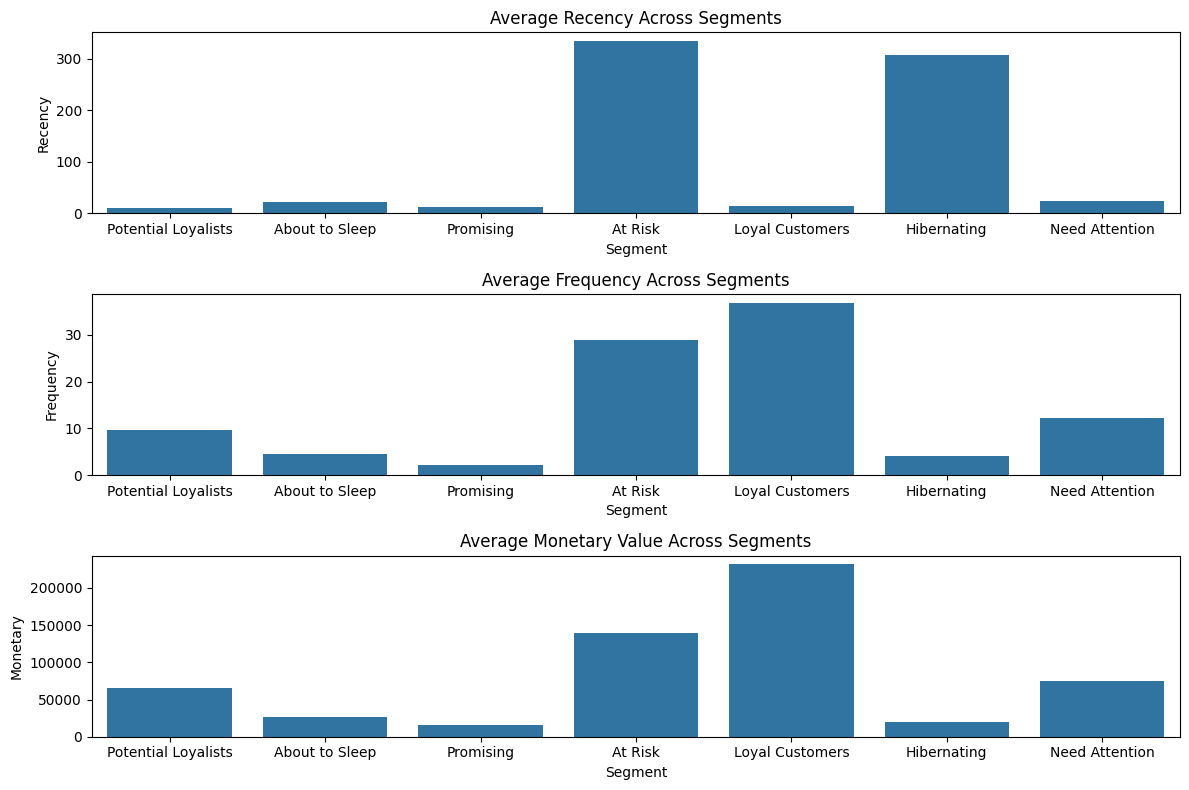

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 8))

# Create bar charts for average Recency, Frequency, and Monetary values across segments
plt.subplot(3, 1, 1)
sns.barplot(x='Segment', y='Recency', data=rfm1, ci=None)
plt.title('Average Recency Across Segments')

plt.subplot(3, 1, 2)
sns.barplot(x='Segment', y='Frequency', data=rfm1, ci=None)
plt.title('Average Frequency Across Segments')

plt.subplot(3, 1, 3)
sns.barplot(x='Segment', y='Monetary', data=rfm1, ci=None)
plt.title('Average Monetary Value Across Segments')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



<Figure size 1200x800 with 0 Axes>

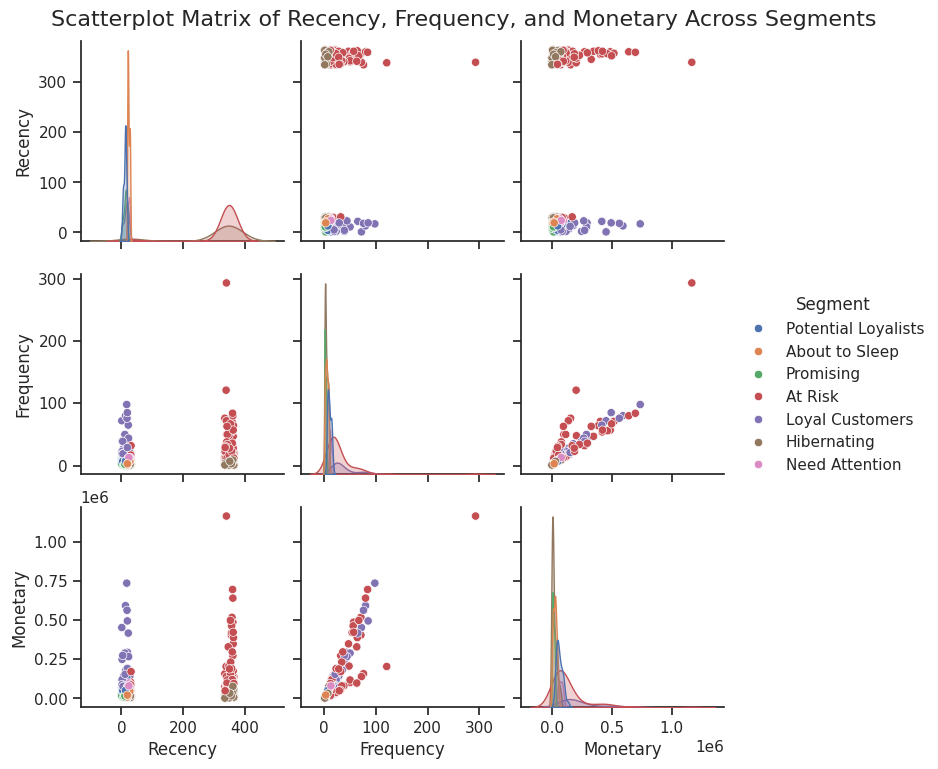

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a scatterplot matrix for Recency, Frequency, and Monetary values across segments
sns.set(style="ticks")
sns.pairplot(rfm1[['Recency', 'Frequency', 'Monetary', 'Segment']], hue='Segment')

# Add titles
plt.suptitle('Scatterplot Matrix of Recency, Frequency, and Monetary Across Segments', y=1.02, size=16)

# Show the plot
plt.show()



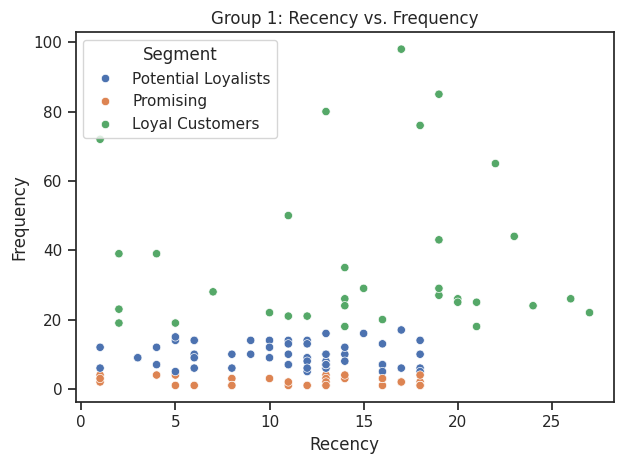

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define groups
group1 = ['Promising', 'Potential Loyalists', 'Loyal Customers']
group2 = ['Hibernating', 'About to Sleep']
group3 = ['At Risk', 'Need Attention']

sns.scatterplot(x='Recency', y='Frequency', hue='Segment', data=rfm1[rfm1['Segment'].isin(group1)])
plt.title('Group 1: Recency vs. Frequency')


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


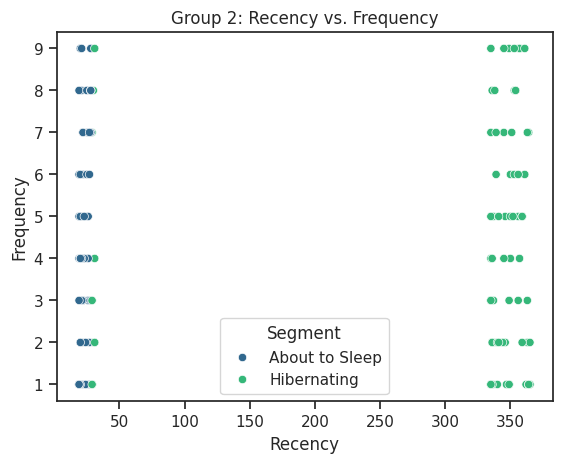

In [45]:
sns.scatterplot(x='Recency', y='Frequency', hue='Segment', data=rfm1[rfm1['Segment'].isin(group2)], palette='viridis')
plt.title('Group 2: Recency vs. Frequency')
# Show the plot
plt.show()

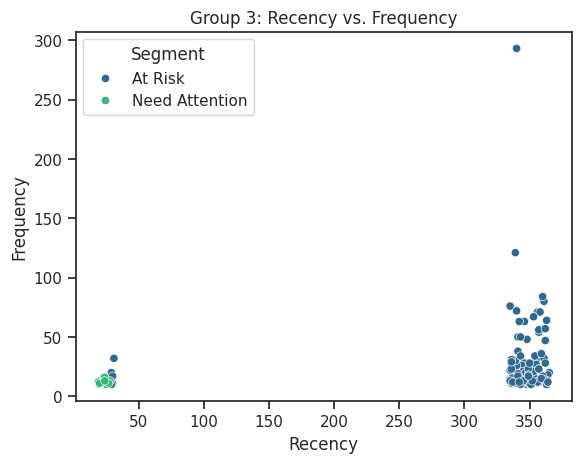

In [44]:
# Visualization for Group 3
sns.scatterplot(x='Recency', y='Frequency', hue='Segment', data=rfm1[rfm1['Segment'].isin(group3)], palette='viridis')
plt.title('Group 3: Recency vs. Frequency')
# Show the plot
plt.show()